In [6]:
import tensorflow as tf
from tensorflow import keras    
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras import layers, models
from modules import utils, CallBacks, History, PreTrain
from tensorflow.keras import Model
import pickle
import seaborn as sns

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
image_size = 150
batch_size = 32
epochs = 50

In [10]:
data_folder = 'data\data1\Tomato'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f"{data_folder}",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size,
)

Found 16011 files belonging to 10 classes.


In [11]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Tomato_YellowLeaf_Curl_Virus',
 'Tomato_Tomato_mosaic_virus',
 'Tomato_healthy']

In [12]:
class_dis = [len(os.listdir(f'{data_folder}\{name}')) for name in class_names]
class_dis

[2127, 1000, 1909, 952, 1771, 1676, 1404, 3209, 373, 1591]

In [8]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

Shape of one batch and labels:
(32, 150, 150, 3)
[5 2 7 0 5 7 4 5 2 0 4 2 2 9 0 0 4 6 9 4 1 3 7 2 4 1 4 9 9 0 6 8]


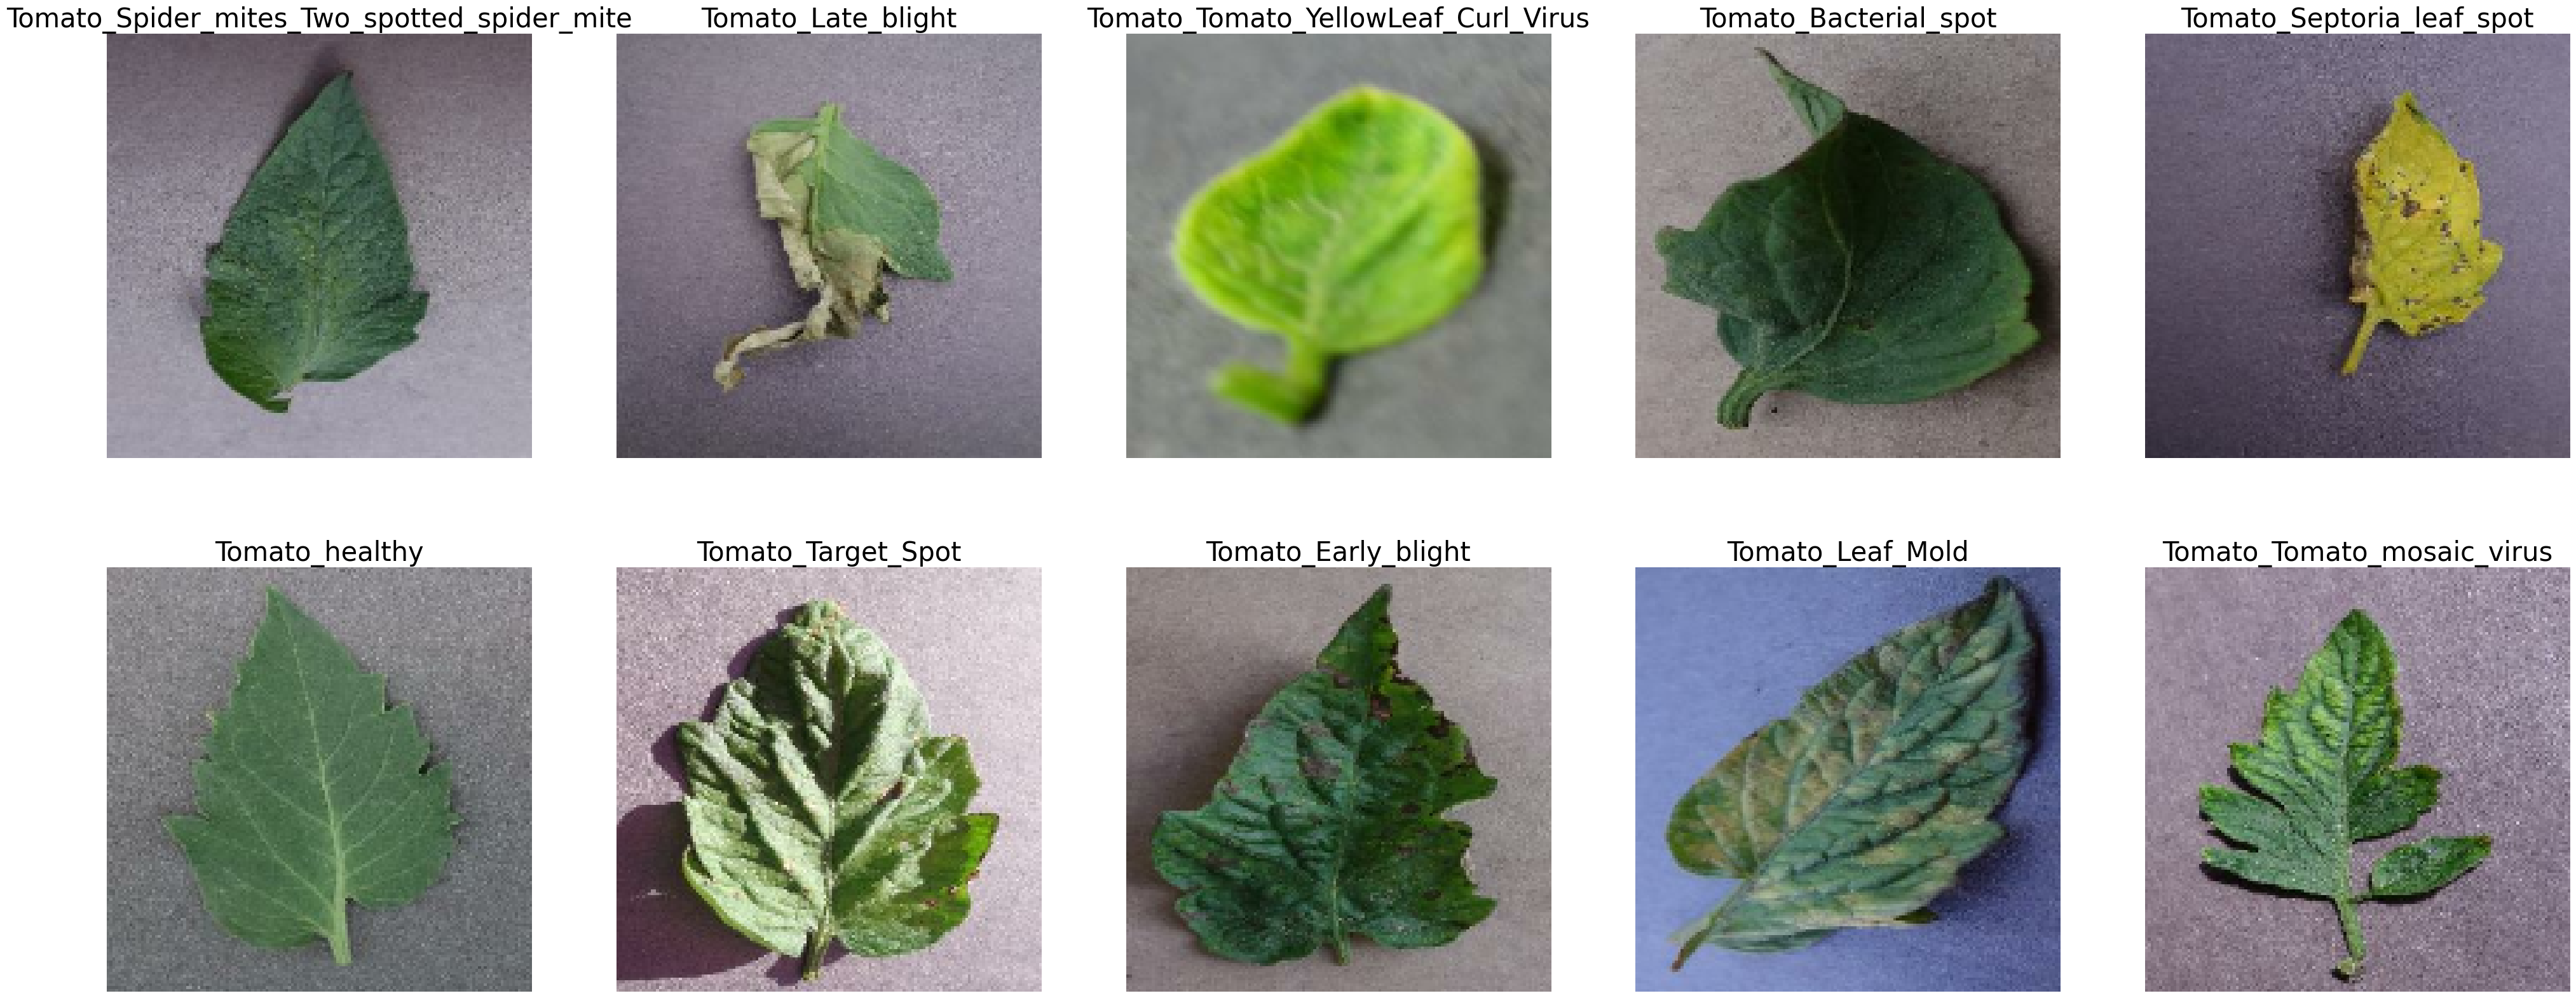

In [27]:
plt.figure(figsize=(50,20))
classes = []
for images, labels in dataset:
    if len(classes)==0:
        print('Shape of one batch and labels:')
        print(images.shape)
        print(labels.numpy())
    for image, label in zip(images, labels):
        if class_names[label] not in classes:
            ax = plt.subplot(2,5,len(classes)+1)
            plt.imshow(image.numpy().astype(int)) 
            plt.axis('off')
            plt.title(class_names[label], fontsize=30)
            classes.append(class_names[label])
        if len(classes)==10: break
    

In [15]:
train, val, test = utils.dataset_partition(dataset)
print(len(train), len(val), len(test))
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

400 50 51


In [16]:
# Data preprocessing
data_preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [25]:
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Set up compile
opt_adam = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
metric = 'accuracy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Callback
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = CallBacks.checkpoint_call('tomato')

steps_per_epoch = len(train)
validation_steps = len(val)

input_shape = (batch_size, image_size, image_size, 3)

In [12]:
# Build CNN model

model = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 150, 150, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 148, 148, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 148, 148, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (32, 74, 74, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 72, 72, 64)         

In [29]:
model.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [31]:
hist = model.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 0.8884 - accuracy: 0.7390
Epoch 1: val_loss did not improve from 0.30271
400/400 [==============================] - 39s 93ms/step - loss: 0.8884 - accuracy: 0.7390 - val_loss: 11.0901 - val_accuracy: 0.2144
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8551
Epoch 2: val_loss did not improve from 0.30271
400/400 [==============================] - 33s 83ms/step - loss: 0.4254 - accuracy: 0.8551 - val_loss: 0.7367 - val_accuracy: 0.7869
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 0.3170 - accuracy: 0.8919
Epoch 3: val_loss did not improve from 0.30271
400/400 [==============================] - 30s 75ms/step - loss: 0.3170 - accuracy: 0.8919 - val_loss: 0.6513 - val_accuracy: 0.8094
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9084
Epoch 4: val_loss did not improve from 0.30271
400/400 [===================

In [34]:
CallBacks.load_latest_checkpoint(model, 'tomato')

checkpoints/tomato/1\22.ckpt


51/51 [==============================] - 17s 31ms/step - loss: 0.2693 - accuracy: 0.9268


[0.2692909836769104, 0.926753580570221]

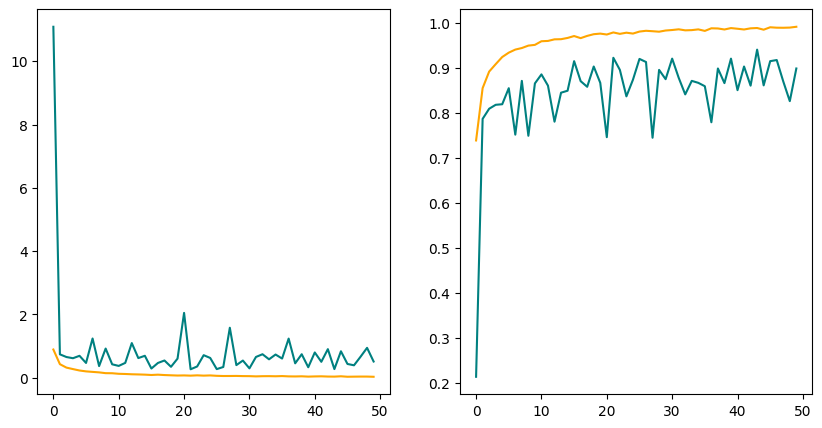

In [35]:
History.plot_loss_metric(hist)
scores = model.evaluate(test)
scores

In [42]:
base_model, base_model_output = PreTrain.get_ResNet50(image_size=image_size)

x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.build(input_shape=input_shape)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [43]:
model.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [45]:
hist = model.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.8213
Epoch 1: val_loss did not improve from 0.26391
400/400 [==============================] - 62s 153ms/step - loss: 0.6493 - accuracy: 0.8213 - val_loss: 0.3306 - val_accuracy: 0.8969
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9287
Epoch 2: val_loss did not improve from 0.26391
400/400 [==============================] - 59s 147ms/step - loss: 0.2142 - accuracy: 0.9287 - val_loss: 0.2840 - val_accuracy: 0.9144
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9623
Epoch 3: val_loss improved from 0.26391 to 0.25621, saving model to checkpoints/tomato/1\3.ckpt
400/400 [==============================] - 55s 137ms/step - loss: 0.1218 - accuracy: 0.9623 - val_loss: 0.2562 - val_accuracy: 0.9244
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9754
Epoch 4: val_loss improv

In [46]:
hist_1 = model.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist.epoch[-1],
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 10/20
400/400 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9998
Epoch 10: val_loss did not improve from 0.16912
400/400 [==============================] - 57s 142ms/step - loss: 0.0076 - accuracy: 0.9998 - val_loss: 0.1878 - val_accuracy: 0.9475
Epoch 11/20
400/400 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 1.0000
Epoch 11: val_loss did not improve from 0.16912
400/400 [==============================] - 54s 136ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.1772 - val_accuracy: 0.9494
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000
Epoch 12: val_loss did not improve from 0.16912
400/400 [==============================] - 50s 126ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1776 - val_accuracy: 0.9488
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000
Epoch 13: val_loss did not improve from 0.16912
400/400 [=========

In [52]:
base_model, base_model_output = PreTrain.get_ResNet50()

x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model_dropout = Model(inputs=base_model.input, outputs=x)

print(model.summary())

CallBacks.load_latest_checkpoint(model_dropout, 'tomato')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [53]:
model_dropout.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [54]:
hist_dropout = model.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 5.3800e-04 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.16912
400/400 [==============================] - 63s 158ms/step - loss: 5.3800e-04 - accuracy: 1.0000 - val_loss: 0.1912 - val_accuracy: 0.9500
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 4.2620e-04 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 0.16912
400/400 [==============================] - 58s 144ms/step - loss: 4.2620e-04 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9513
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 3.6000e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.16912
400/400 [==============================] - 62s 155ms/step - loss: 3.6000e-04 - accuracy: 1.0000 - val_loss: 0.1876 - val_accuracy: 0.9538
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 2.9584e-04 - accuracy: 1.0000
Epoch 4: val_loss did not improve from 0.1691

In [ ]:
import matplotlib.pyplot as plt

hist_model1 = History.merge_hist([hist, hist_1, hist_dropout])

History.save_hist(hist_model1, 'model1')

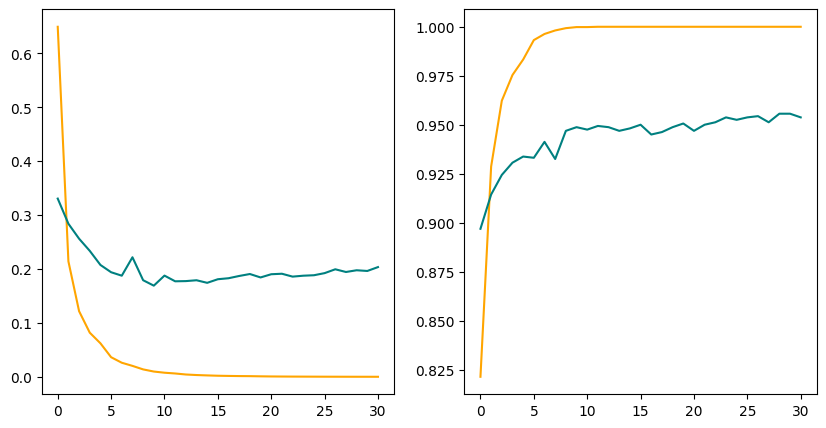

In [13]:
hist_model1 = History.load_hist('tomato')
History.plot_loss_metric(hist_model1, dic=True)

In [103]:
CallBacks.load_lastest_checkpoint(model_dropout, 'tomato')
scores = model_dropout.evaluate(test)
scores

Loaded:  checkpoints/tomato/1\10.ckpt
51/51 [==============================] - 6s 103ms/step - loss: 0.2141 - accuracy: 0.9323


[0.21409492194652557, 0.932340145111084]

In [105]:
utils.save_model(model, 'tomato')

INFO:tensorflow:Assets written to: models/tomato/4\assets


In [12]:
base_model, base_model_output = PreTrain.get_ResNet50(image_size=image_size)
base_model_output = base_model.layers[-2].output
base_model = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

In [14]:
x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model_ResNet50_v2 = Model(inputs=base_model.input, outputs=x)

print(model_ResNet50_v2.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [15]:
model_ResNet50_v2.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [16]:
hist = model_ResNet50_v2.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8575
Epoch 1: val_loss improved from inf to 0.22496, saving model to checkpoints/tomato/4\1.ckpt
400/400 [==============================] - 75s 117ms/step - loss: 0.4778 - accuracy: 0.8575 - val_loss: 0.2250 - val_accuracy: 0.9269
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0647 - accuracy: 0.9798
Epoch 2: val_loss improved from 0.22496 to 0.18782, saving model to checkpoints/tomato/4\2.ckpt
400/400 [==============================] - 38s 94ms/step - loss: 0.0647 - accuracy: 0.9798 - val_loss: 0.1878 - val_accuracy: 0.9400
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.9917
Epoch 3: val_loss improved from 0.18782 to 0.15752, saving model to checkpoints/tomato/4\3.ckpt
400/400 [==============================] - 35s 88ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.1575 - val_accuracy: 0.9506
Epoch 4/10
400/400 [========

In [17]:
hist1 = model_ResNet50_v2.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch = hist.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 11/20
400/400 [==============================] - ETA: 0s - loss: 1.0412e-04 - accuracy: 1.0000
Epoch 11: val_loss improved from 0.10287 to 0.10166, saving model to checkpoints/tomato/4\11.ckpt
400/400 [==============================] - 35s 86ms/step - loss: 1.0412e-04 - accuracy: 1.0000 - val_loss: 0.1017 - val_accuracy: 0.9675
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 8.7731e-05 - accuracy: 1.0000
Epoch 12: val_loss improved from 0.10166 to 0.10005, saving model to checkpoints/tomato/4\12.ckpt
400/400 [==============================] - 35s 86ms/step - loss: 8.7731e-05 - accuracy: 1.0000 - val_loss: 0.1000 - val_accuracy: 0.9688
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 7.3714e-05 - accuracy: 1.0000
Epoch 13: val_loss did not improve from 0.10005
400/400 [==============================] - 33s 82ms/step - loss: 7.3714e-05 - accuracy: 1.0000 - val_loss: 0.1020 - val_accuracy: 0.9681
Epoch 14/20
400/400 [=====================

In [15]:
x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model_ResNet50_v3 = Model(inputs=base_model.input, outputs=x)

CallBacks.load_latest_checkpoint(model_ResNet50_v3, 'tomato')

Loaded:  checkpoints/tomato/4\12.ckpt


In [20]:
model_ResNet50_v3.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [21]:
hist_2 = model_ResNet50_v3.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.5069 - accuracy: 0.8519
Epoch 1: val_loss did not improve from 0.10005
400/400 [==============================] - 45s 104ms/step - loss: 0.5069 - accuracy: 0.8519 - val_loss: 0.2214 - val_accuracy: 0.9519
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9614
Epoch 2: val_loss did not improve from 0.10005
400/400 [==============================] - 44s 111ms/step - loss: 0.1709 - accuracy: 0.9614 - val_loss: 0.1598 - val_accuracy: 0.9613
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9843
Epoch 3: val_loss did not improve from 0.10005
400/400 [==============================] - 41s 104ms/step - loss: 0.0944 - accuracy: 0.9843 - val_loss: 0.1458 - val_accuracy: 0.9613
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.0591 - accuracy: 0.9934
Epoch 4: val_loss did not improve from 0.10005
400/400 [=================

In [23]:
hist_3 = model_ResNet50_v3.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch = hist_2.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 11/20
400/400 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9998
Epoch 11: val_loss did not improve from 0.07401
400/400 [==============================] - 46s 113ms/step - loss: 0.0090 - accuracy: 0.9998 - val_loss: 0.0755 - val_accuracy: 0.9762
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9999
Epoch 12: val_loss improved from 0.07401 to 0.07279, saving model to checkpoints/tomato/4\12.ckpt
400/400 [==============================] - 45s 111ms/step - loss: 0.0072 - accuracy: 0.9999 - val_loss: 0.0728 - val_accuracy: 0.9794
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 1.0000
Epoch 13: val_loss did not improve from 0.07279
400/400 [==============================] - 40s 100ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0754 - val_accuracy: 0.9769
Epoch 14/20
400/400 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9996
Epoch 14: val_lo

In [37]:
model_ResNet50_v3.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [ ]:
hist_ResNet50_v3 = History.merge_hist([hist, hist1, hist_2, hist_3])
History.save_hist(hist_ResNet50_v3, 'tomato')

In [23]:
x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model_ResNet50_v4 = Model(inputs=base_model.input, outputs=x)

CallBacks.load_latest_checkpoint(model_ResNet50_v4, 'tomato')

Loaded:  checkpoints/tomato/4\12.ckpt


In [20]:
hist_load = History.load_hist('tomato')

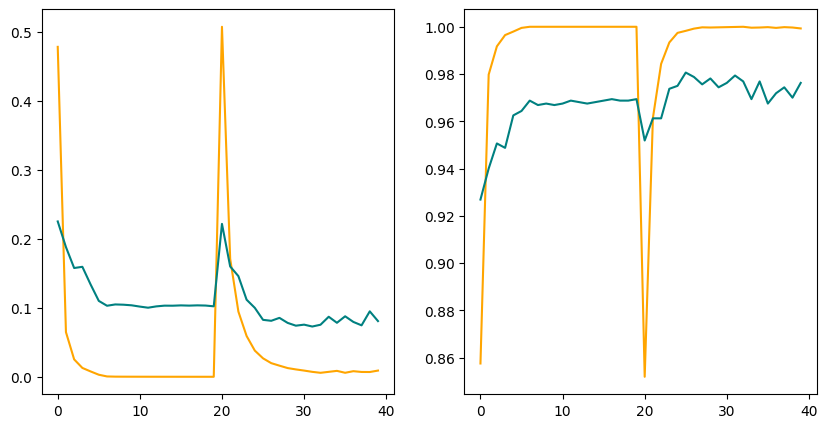

In [18]:
History.plot_loss_metric(hist_load,dic=True)

In [24]:
model_ResNet50_v4.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [25]:
hist_4 = model_ResNet50_v4.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9884
Epoch 1: val_loss improved from inf to 0.05648, saving model to checkpoints/tomato/5\1.ckpt
400/400 [==============================] - 49s 115ms/step - loss: 0.0384 - accuracy: 0.9884 - val_loss: 0.0565 - val_accuracy: 0.9800
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9984
Epoch 2: val_loss improved from 0.05648 to 0.03660, saving model to checkpoints/tomato/5\2.ckpt
400/400 [==============================] - 39s 97ms/step - loss: 0.0084 - accuracy: 0.9984 - val_loss: 0.0366 - val_accuracy: 0.9894
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.03660 to 0.03340, saving model to checkpoints/tomato/5\3.ckpt
400/400 [==============================] - 37s 93ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0334 - val_accuracy: 0.9912
Epoch 4/10
400/400 [========

In [53]:
CallBacks.load_latest_checkpoint(model_ResNet50_v4, 'tomato')
utils.save_model(model_ResNet50_v4, 'tomato')

Loaded:  checkpoints/tomato/5\7.ckpt
INFO:tensorflow:Assets written to: models/tomato/5\assets


In [16]:
scores = model_ResNet50_v4.evaluate(test)
scores

51/51 [==============================] - 16s 73ms/step - loss: 0.0090 - accuracy: 0.9981


[0.008971616625785828, 0.9981378316879272]

In [45]:
x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model_ResNet50_v5 = Model(inputs=base_model.input, outputs=x)

CallBacks.load_checkpoint(model_ResNet50_v5, directory='tomato', checkpoint_name='4/12')

Loaded:  checkpoints/tomato/4/12.ckpt


In [46]:
model_ResNet50_v5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [47]:
model_ResNet50_v5.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [48]:
hist_ResNet50_v5_1 = model_ResNet50_v5.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.8458
Epoch 1: val_loss improved from inf to 0.09623, saving model to checkpoints/tomato/6\1.ckpt
400/400 [==============================] - 60s 117ms/step - loss: 0.6091 - accuracy: 0.8458 - val_loss: 0.0962 - val_accuracy: 0.9706
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.1749 - accuracy: 0.9423
Epoch 2: val_loss improved from 0.09623 to 0.06507, saving model to checkpoints/tomato/6\2.ckpt
400/400 [==============================] - 43s 106ms/step - loss: 0.1749 - accuracy: 0.9423 - val_loss: 0.0651 - val_accuracy: 0.9787
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9613
Epoch 3: val_loss improved from 0.06507 to 0.05891, saving model to checkpoints/tomato/6\3.ckpt
400/400 [==============================] - 46s 114ms/step - loss: 0.1128 - accuracy: 0.9613 - val_loss: 0.0589 - val_accuracy: 0.9800
Epoch 4/10
400/400 [======

In [50]:
hist_ResNet50_v5_2 = model_ResNet50_v5.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist_ResNet50_v5_1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 11/20
400/400 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9884
Epoch 11: val_loss did not improve from 0.03556
400/400 [==============================] - 61s 152ms/step - loss: 0.0382 - accuracy: 0.9884 - val_loss: 0.0463 - val_accuracy: 0.9862
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9874
Epoch 12: val_loss did not improve from 0.03556
400/400 [==============================] - 61s 152ms/step - loss: 0.0403 - accuracy: 0.9874 - val_loss: 0.0450 - val_accuracy: 0.9875
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9877
Epoch 13: val_loss did not improve from 0.03556
400/400 [==============================] - 58s 146ms/step - loss: 0.0367 - accuracy: 0.9877 - val_loss: 0.0372 - val_accuracy: 0.9875
Epoch 14/20
400/400 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9920
Epoch 14: val_loss did not improve from 0.03556
400/400 [=========

In [51]:
hist_ResNet50_v5_3 = model_ResNet50_v5.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist_ResNet50_v5_2.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 21/30
400/400 [==============================] - ETA: 0s - loss: 0.0182 - accuracy: 0.9934
Epoch 21: val_loss did not improve from 0.03134
400/400 [==============================] - 62s 154ms/step - loss: 0.0182 - accuracy: 0.9934 - val_loss: 0.0647 - val_accuracy: 0.9850
Epoch 22/30
400/400 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9902
Epoch 22: val_loss did not improve from 0.03134
400/400 [==============================] - 60s 150ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.0407 - val_accuracy: 0.9837
Epoch 23/30
400/400 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9937
Epoch 23: val_loss did not improve from 0.03134
400/400 [==============================] - 51s 128ms/step - loss: 0.0183 - accuracy: 0.9937 - val_loss: 0.0397 - val_accuracy: 0.9887
Epoch 24/30
400/400 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9934
Epoch 24: val_loss did not improve from 0.03134
400/400 [=========

In [52]:
CallBacks.load_latest_checkpoint(model_ResNet50_v5, 'tomato') 
scores = model_ResNet50_v5.evaluate(test)
scores

Loaded:  checkpoints/tomato/6\15.ckpt
51/51 [==============================] - 7s 130ms/step - loss: 0.0615 - accuracy: 0.9839


[0.06153719127178192, 0.983860969543457]

In [22]:
base_model, base_model_output = PreTrain.get_ResNet101(image_size=image_size)
base_model_output = base_model.layers[-2].output
base_model = tf.keras.Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

x = Flatten()(base_model_output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(num_classes, activation='softmax')(x)

model_ResNet101_v1 = Model(inputs=base_model.input, outputs=x)

model_ResNet101_v1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']       

In [23]:
model_ResNet101_v1.compile(
    metrics=[metric],
    optimizer=opt_adam,
    loss=loss,
)

checkpoint_callback = CallBacks.checkpoint_call('tomato')

In [26]:
hist_ResNet101_v1_1 = model_ResNet101_v1.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8887
Epoch 1: val_loss improved from inf to 0.21805, saving model to checkpoints/tomato/8\1.ckpt
400/400 [==============================] - 142s 273ms/step - loss: 0.3534 - accuracy: 0.8887 - val_loss: 0.2180 - val_accuracy: 0.9312
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9910
Epoch 2: val_loss improved from 0.21805 to 0.18704, saving model to checkpoints/tomato/8\2.ckpt
400/400 [==============================] - 95s 237ms/step - loss: 0.0377 - accuracy: 0.9910 - val_loss: 0.1870 - val_accuracy: 0.9381
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9997
Epoch 3: val_loss improved from 0.18704 to 0.11457, saving model to checkpoints/tomato/8\3.ckpt
400/400 [==============================] - 96s 240ms/step - loss: 0.0076 - accuracy: 0.9997 - val_loss: 0.1146 - val_accuracy: 0.9650
Epoch 4/10
400/400 [=====

In [27]:
hist_MobileNet_v1_2 = model_ResNet101_v1.fit(
    train,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    validation_steps=validation_steps,
    initial_epoch=hist_ResNet101_v1_1.epoch[-1]+1,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 11/20
400/400 [==============================] - ETA: 0s - loss: 2.0503e-04 - accuracy: 1.0000
Epoch 11: val_loss did not improve from 0.10711
400/400 [==============================] - 97s 241ms/step - loss: 2.0503e-04 - accuracy: 1.0000 - val_loss: 0.1091 - val_accuracy: 0.9681
Epoch 12/20
400/400 [==============================] - ETA: 0s - loss: 1.6347e-04 - accuracy: 1.0000
Epoch 12: val_loss did not improve from 0.10711
400/400 [==============================] - 95s 237ms/step - loss: 1.6347e-04 - accuracy: 1.0000 - val_loss: 0.1073 - val_accuracy: 0.9694
Epoch 13/20
400/400 [==============================] - ETA: 0s - loss: 1.3122e-04 - accuracy: 1.0000
Epoch 13: val_loss did not improve from 0.10711
400/400 [==============================] - 90s 225ms/step - loss: 1.3122e-04 - accuracy: 1.0000 - val_loss: 0.1088 - val_accuracy: 0.9694
Epoch 14/20
400/400 [==============================] - ETA: 0s - loss: 1.0601e-04 - accuracy: 1.0000
Epoch 14: val_loss did not improve fro

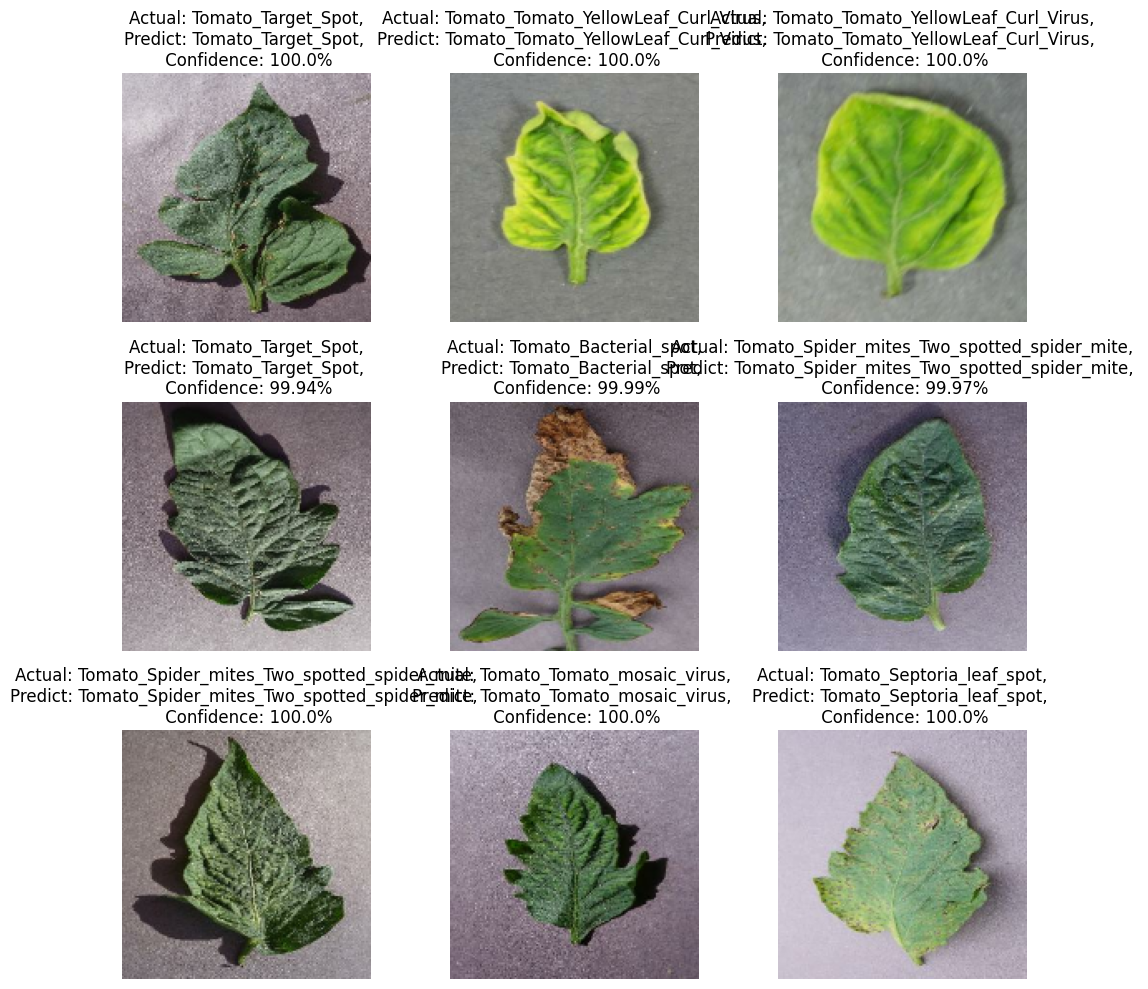

In [28]:
is_break = False
while not is_break:
    for images, labels in test.take(1):
        num_img = 9
        if len(images)>=num_img:
            is_break = True
            fig = plt.figure(figsize=(10,10))
            for i in range(num_img):
                ax = plt.subplot(3,3,i+1)
                predict_label, confidence = utils.predict(model_ResNet50_v4, images[i], class_names)
                actual_label = class_names[labels[i]]
                plt.imshow(images[i].numpy().astype(int))
                plt.title(f'Actual: {actual_label},\nPredict: {predict_label}, \n Confidence: {confidence}%', fontsize=12)
                plt.axis('off')

            fig.tight_layout()

Average Precision:
0.9984716157205239
Average Recall:
0.9983017952450267
F1 Score:
0.9983866982613766
Confusion Matrix:
[[220   0   0   0   0   0   0   0   0   0]
 [  0  92   0   0   0   0   0   0   0   0]
 [  0   0 201   1   0   0   0   0   0   0]
 [  0   0   0 106   0   0   0   0   0   0]
 [  1   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0 173   0   0   0   0]
 [  0   0   0   0   1   0 123   0   0   0]
 [  0   0   0   0   0   0   0 332   0   0]
 [  0   0   0   0   0   0   0   0  35   0]
 [  0   0   0   0   0   0   0   0   0 157]]


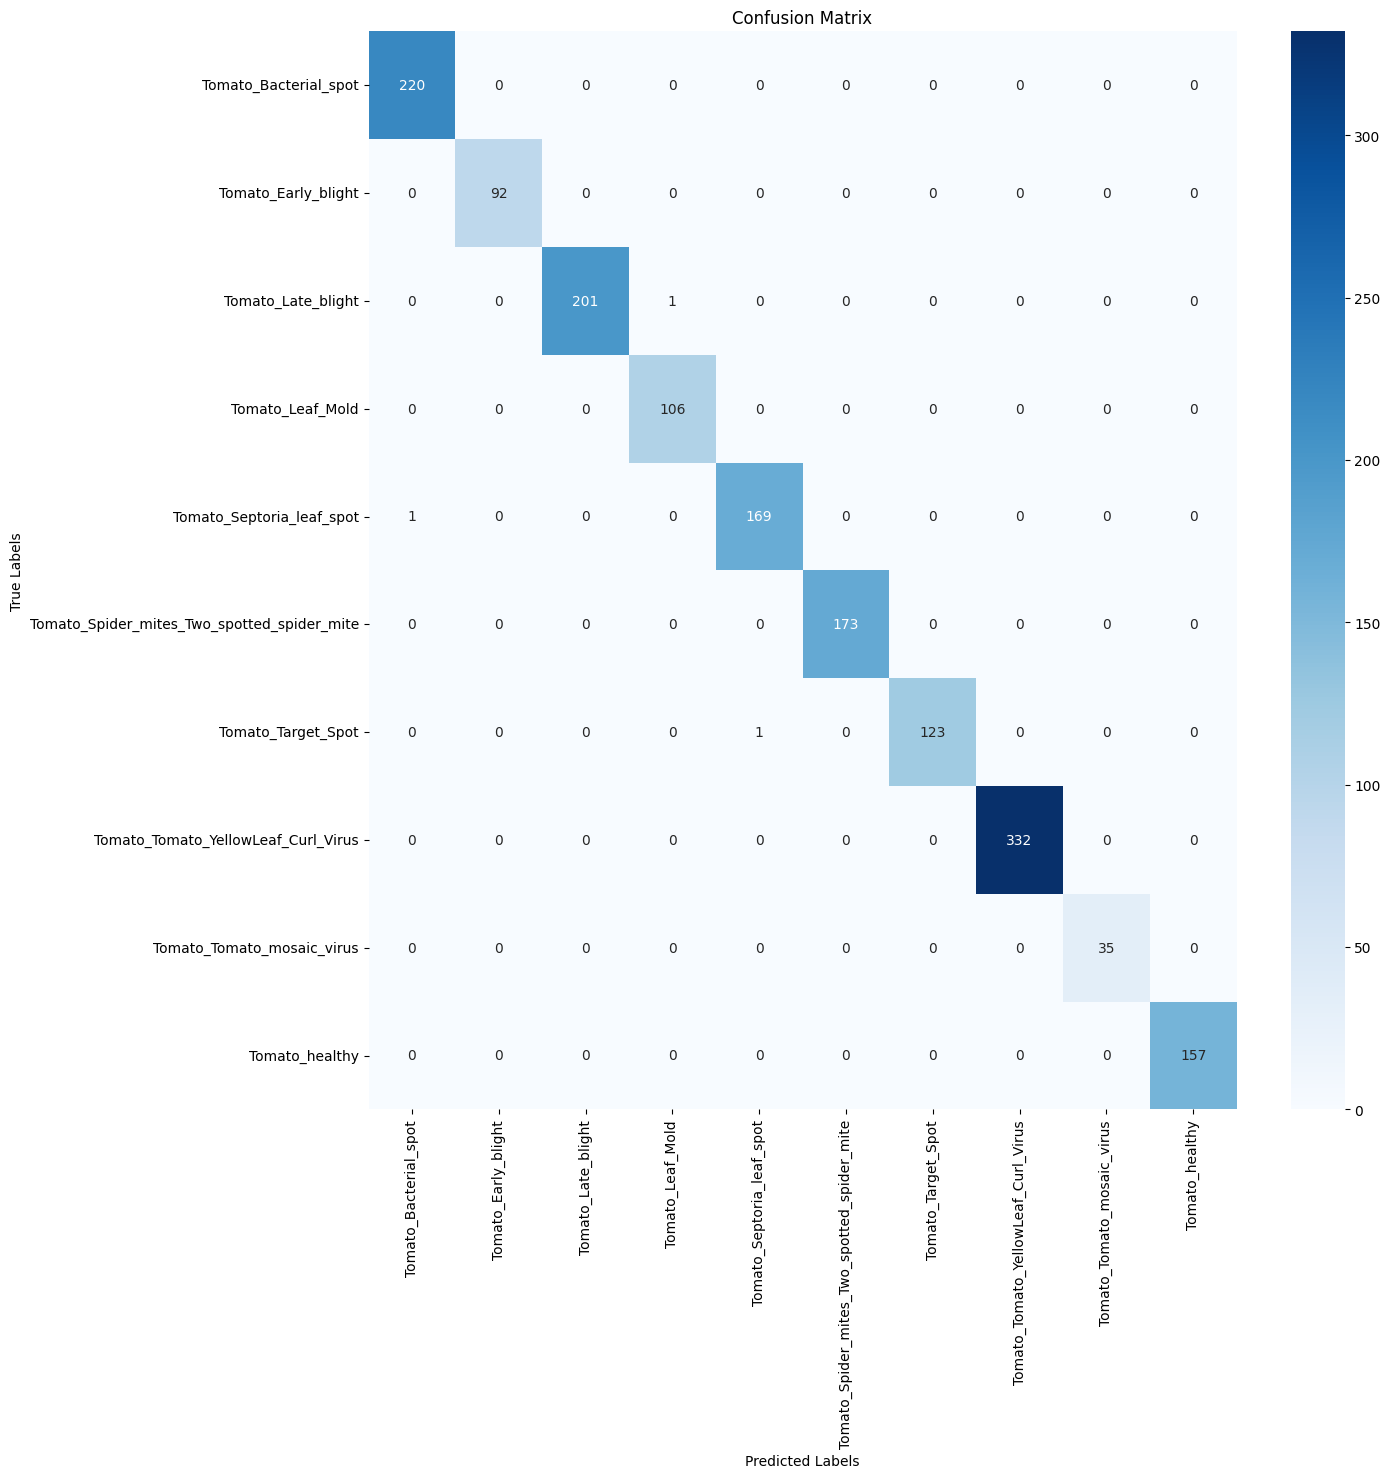

In [36]:
_, _, _, cf_matrix = utils.precision_recall(model_ResNet50_v4, test)
utils.confusion_heatmap(cf_matrix, class_names)